### NYC TAXI DATA CHALENGE

In [465]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 


#### 1.1) Programmatically download and load into your favorite analytical tool the trip data for September 2015

To start with the NYC Data Challenge we first try to import various python packages that we need for our analysis.We then dowload the NYC green taxi data for September 2015 from "https://s3.amazonaws.com/nyc-tlc/trip+data" and store it in a Pandas DataFrame.Dataframe is a 2D labeled data structure with columns of potentiall different types.Just like excel it provides functionalities to analyze,change and extract valuable information fom the dataset

In [2]:
url='https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
data=pd.read_csv(url)

#### 1.2) Report how many rows and columns of data you have loaded.

In [4]:
nrows=data.shape[0]
ncols=data.shape[1]
print("The total number of rows in the NYC Green Taxi Dataset is {}".format(nrows))
print("The total number of columns in the NYC Green Taxi Dataset is {}".format(ncols))

The total number of rows in the NYC Green Taxi Dataset is 1494926
The total number of columns in the NYC Green Taxi Dataset is 21


### Question 2

#### 2.1) Plot a histogram of the number of the trip distance (“Trip Distance”).

Before trying to plot a histogram of "Trip Distance",let us first understand the intution behind a Histogram Plot.
A histogram is  used to graphically summarize and display frequency of continuous dataset where the bins represent the range of the data and height represents frequency of data in that particular bin(range)

I have used Python's Seaborn package to plot the histogram.Seaborn's distplot()  uses a simple rule to make a good guess of the right number of bins by default which can be changed to reveal interesting patterns in the data

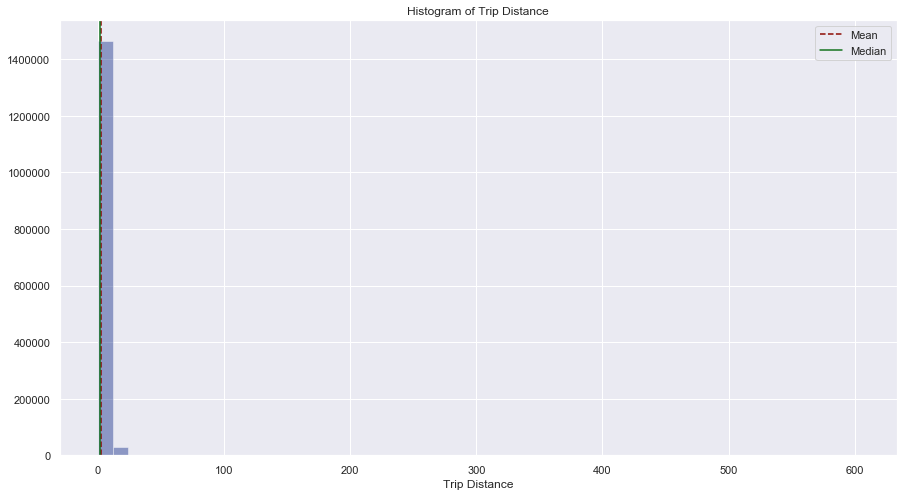

In [29]:
plt.figure(figsize=(15,8))
sns.set(style='darkgrid',palette="dark", color_codes=True)
sns.distplot(data['Trip_distance'],hist=True,kde=False).set_title("Histogram of Trip Distance")
plt.axvline(data['Trip_distance'].mean(), color='r', linestyle='--')
plt.axvline(data['Trip_distance'].median(), color='g', linestyle='-')

plt.xlabel("Trip Distance")
plt.legend({'Mean':data['Trip_distance'].mean(),'Median':data['Trip_distance'].median()})


In [30]:
print("Minimum trip distance travelled in miles is {}.".format(min(data['Trip_distance'])))
print("Maximum trip distance travelled in miles is {}".format(max(data['Trip_distance'])))

Minimum trip distance travelled in miles is 0.0.
Maximum trip distance travelled in miles is 603.1


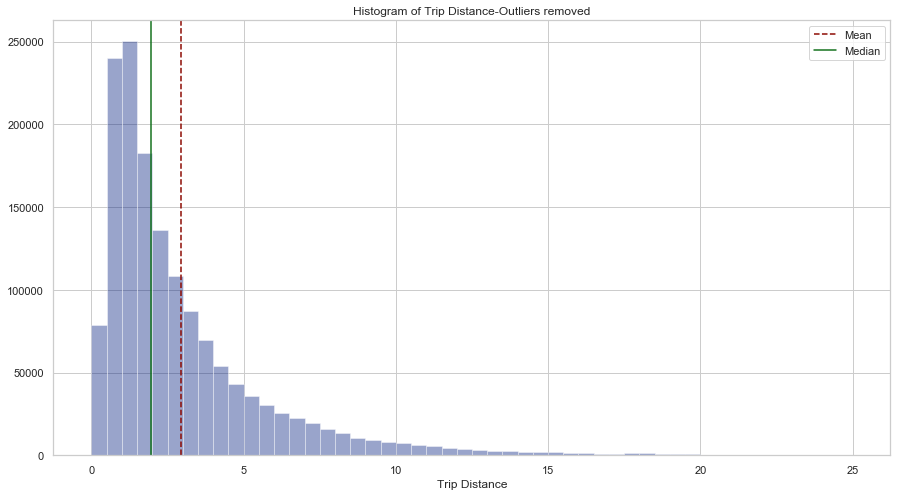

In [100]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid",palette="dark", color_codes=True)
mod_trip_dist=data[data['Trip_distance']<25].Trip_distance
sns.distplot(mod_trip_dist,hist=True,kde=False).set_title("Histogram of Trip Distance-Outliers removed")
plt.xlabel("Trip Distance")
plt.axvline(mod_trip_dist.mean(), color='r', linestyle='--')
plt.axvline(mod_trip_dist.median(), color='g', linestyle='-')

plt.xlabel("Trip Distance")
plt.legend({'Mean':mod_trip_dist.mean(),'Median':mod_trip_dist.median()})


#### 2.2)Report any structure you find and any hypotheses you have about that structure

#### Inference from Histogram of Trip Distance

The histogram of trip distance is a right-skewed histogram with data concentrated between 0-25 and few points are strethed across the X-axis till 600+ miles.
For right skewed data,mean does not provide a good estimate of the centre of the data.In this case median should be used to estimate the centre of the data.From our graphs we can see that mean is greater than the median which is true for any right skewed data.





From the 2nd histogram we eliminate points that looked suspicious.Well,maximum trip distance travelled of 603.1 miles with a public Taxi seems unreasonable and this point might be a wrongle recorded data or might be due to some technical glitch during recording.
Same is the scenario with trips of 0 miles.Seems like someone got into the taxi and immediately changed their mind making the distance travelled to 0 miles.If this is the case then the total amount of such trip should  be  equal to the minimum fare for NYC Green taxis which is $2.50.We will test this hypothesis of ours in the subsequent sections

In [32]:
data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

In [46]:
#Retrieving trip distance with 0 values
dis_zero=data[data['Trip_distance']==0]
#Retrieving trip distance with base fare
dis_amt_base=dis_zero[dis_zero['Fare_amount']==2.50]
pcnt_basefare=len(dis_amt_base)/len(dis_zero)*100
print("Percent of trips with 0 distance and basefare is {}%".format(round(pcnt_basefare,2)))

Percent of trips with 0 distance and basefare is 29.65


We will now check for trips with 0 miles and 0 Fare amount.

In [49]:
dis_amt_base=dis_zero[dis_zero['Fare_amount']==0]
pcnt_zerofare=len(dis_amt_base)/len(dis_zero)*100
print("Percent of trips with 0 distance and basefare is {}%".format(round(pcnt_zerofare,2)))

Percent of trips with 0 distance and basefare is 3.32%


Though both the outputs are not significantly large,we cannot certainly say that our assumption about 0 diastance and minimum fare is coorect but 29.65% definitely shows some significance between the 2.

### Question 3

#### 3.1)  Report mean and median trip distance grouped by hour of day.

In [54]:
data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'pickup_hour',
       'pickup_week'],
      dtype='object')

In [55]:
#Pickup hour and Week
data['lpep_pickup_datetime']=pd.to_datetime(data['lpep_pickup_datetime']) #Converting to datetime object
data['pickup_hour']=data['lpep_pickup_datetime'].dt.hour #Extracting the hour value
data['pickup_week']=data['lpep_pickup_datetime'].dt.dayofweek #Extracting the day of week value
#Drop-off Hour and Week
data['Lpep_dropoff_datetime']=pd.to_datetime(data['Lpep_dropoff_datetime'])  #Converting to datetime object
data['dropoff_hour']=data['Lpep_dropoff_datetime'].dt.hour #Extracting the hour value
data['dropoff_week']=data['Lpep_dropoff_datetime'].dt.dayofweek #Extracting the day of week value

In [78]:
hour_mean_pickup=data[['Trip_distance','pickup_hour']].groupby('pickup_hour').mean()
hour_mean_dropoff=data[['Trip_distance','dropoff_hour']].groupby('dropoff_hour').mean()

Text(0.5,0,'Pickup-hour')

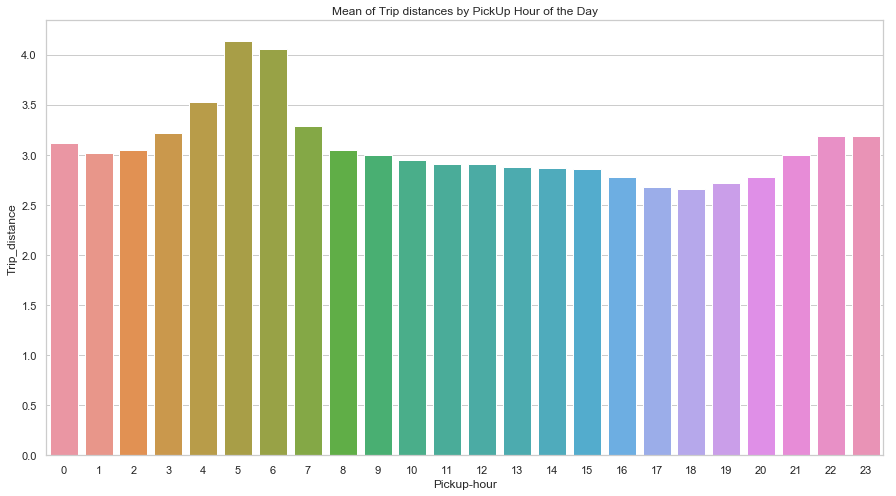

In [94]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x=hour_mean_pickup.index.values, y=hour_mean_pickup['Trip_distance'], data=hour_mean_pickup)
ax.set_title("Mean of Trip distances by PickUp Hour of the Day")
plt.xlabel("Pickup-hour")


The bar plot above summarizes the mean of trip distances grouped by pick up hour of the day.It can be observed that mean of trip distances is most during early morning hours from 4.00 am to 7.00 am.One possibility behind this could be that during these hours people from relatively faraway distance might be entering the city for commercial purposes.The mean trip distance decreases druing the afternoon hours from 1.00pm to 4.00 pm and again increases from 10.00 pm to 1.00 am.

Text(0.5,0,'Drop-off-hour')

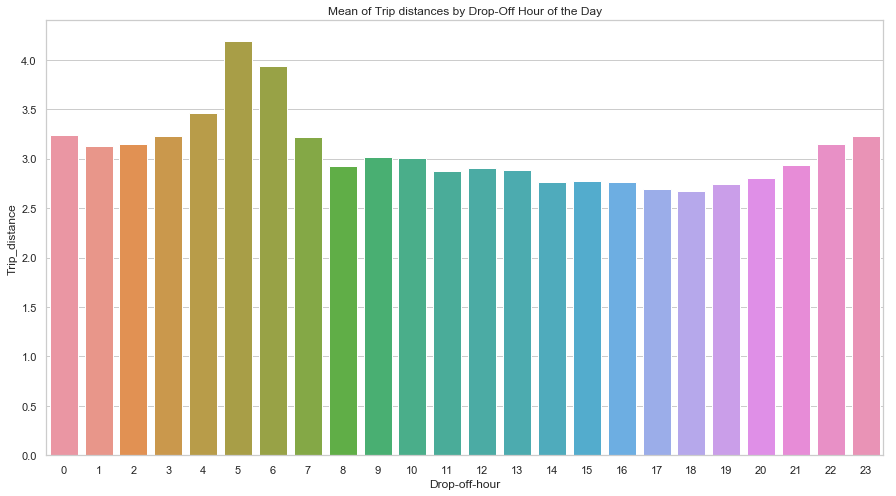

In [95]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x=hour_mean_dropoff.index.values, y=hour_mean_dropoff['Trip_distance'], data=hour_mean_dropoff)
ax.set_title("Mean of Trip distances by Drop-Off Hour of the Day")
plt.xlabel("Drop-off-hour")


In [96]:
hour_median_pickup=data[['Trip_distance','pickup_hour']].groupby('pickup_hour').median()
hour_median_dropoff=data[['Trip_distance','dropoff_hour']].groupby('dropoff_hour').median()

Text(0.5,0,'Pickup-hour')

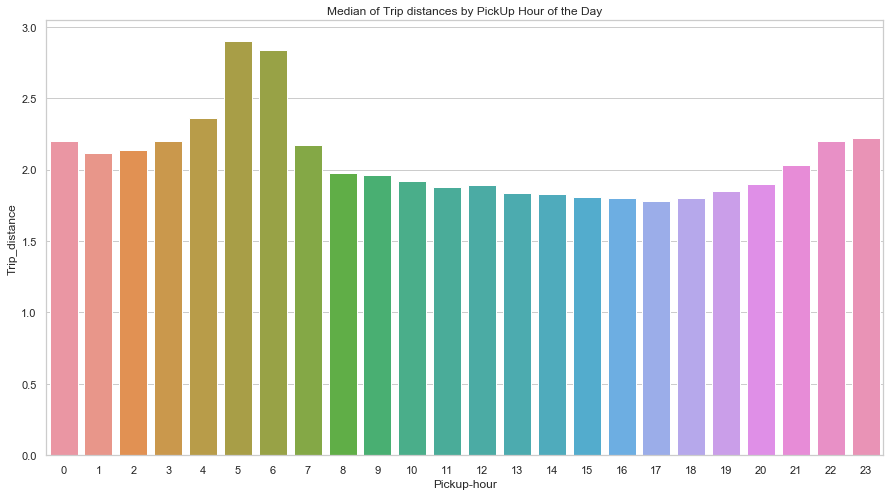

In [97]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x=hour_median_pickup.index.values, y=hour_median_pickup['Trip_distance'], data=hour_median_pickup)
ax.set_title("Median of Trip distances by PickUp Hour of the Day")
plt.xlabel("Pickup-hour")


Text(0.5,0,'DropOff-hour')

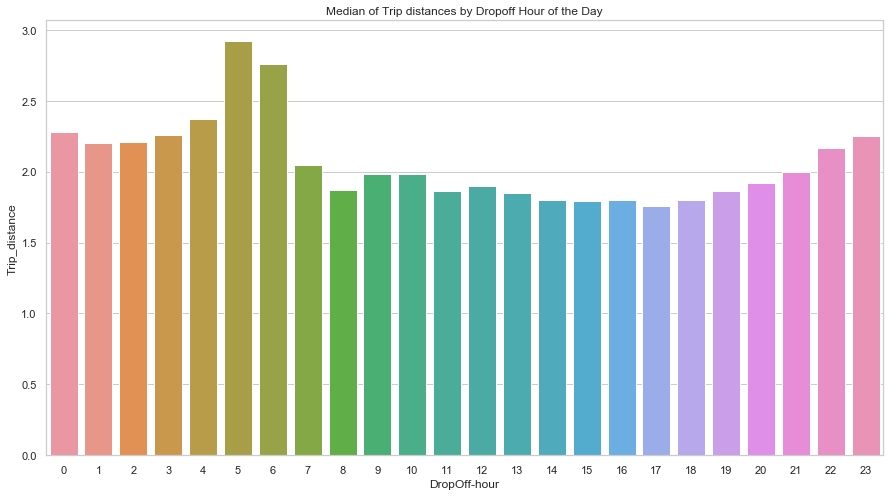

In [98]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x=hour_median_dropoff.index.values, y=hour_median_dropoff['Trip_distance'], data=hour_median_dropoff)
ax.set_title("Median of Trip distances by Dropoff Hour of the Day")
plt.xlabel("DropOff-hour")


Since the trip distance data is right skewed,Median gives a good estimate of the central tendency of the data as mean gets affected by the higher valu points.
The bar plot above summarizes the median of trip distances grouped by pick up hour of the day.It can be observed that median of trip distances is most during early morning hours from 4.00 am to 7.00 am.

In [99]:
week_mean_pickup=data[['Trip_distance','pickup_week']].groupby('pickup_week').mean()
week_mean_dropoff=data[['Trip_distance','dropoff_hour']].groupby('dropoff_hour').mean()

Text(0.5,0,'Pickup-Week')

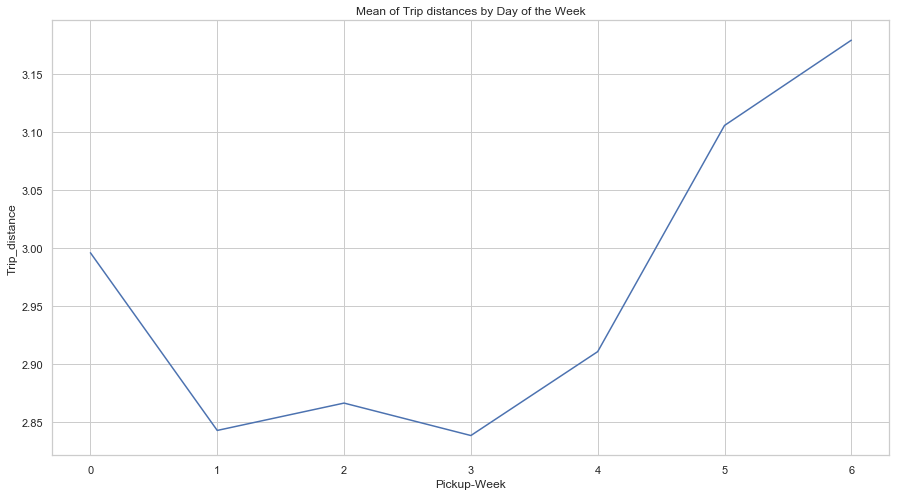

In [107]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.lineplot(x=week_mean_pickup.index.values, y=week_mean_pickup['Trip_distance'], data=week_mean_pickup,markers=True, dashes=False,)
ax.set_title("Mean of Trip distances by Day of the Week")
plt.xlabel("Pickup-Week")


In [109]:
week_median_pickup=data[['Trip_distance','pickup_week']].groupby('pickup_week').median()
week_median_dropoff=data[['Trip_distance','dropoff_hour']].groupby('dropoff_hour').median()

Text(0.5,0,'Pickup-Week')

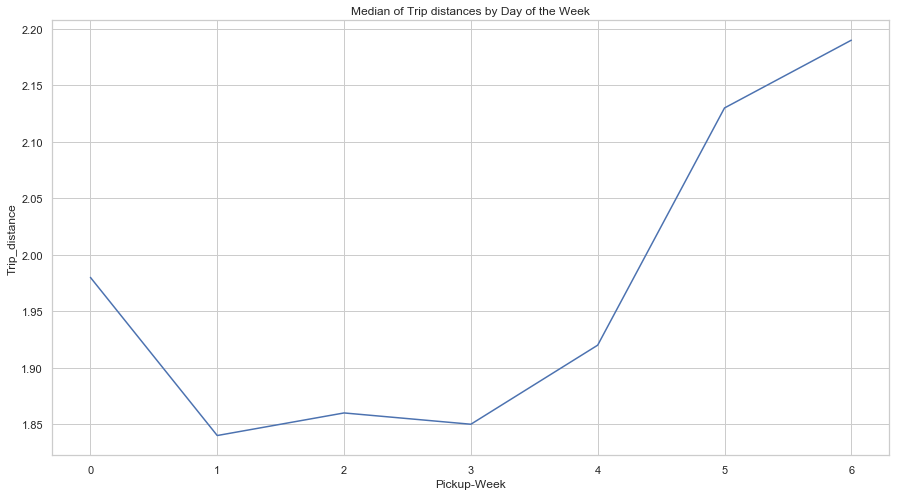

In [111]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.lineplot(x=week_mean_pickup.index.values, y=week_median_pickup['Trip_distance'], data=week_median_pickup,markers=True, dashes=False,)
ax.set_title("Median of Trip distances by Day of the Week")
plt.xlabel("Pickup-Week")


#### Inference from the Hour/Week Plots

From the day of the Week graphs above it can be observed that the trip duration increases towards the end of the week (Friday,Saturday,Sunday) and is lesser during rest of the days.This could be because many people that reside on thte outskirts might be heading home for the weekends and hence increase in trend. 

#### 3.2)We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

In [132]:
#identifyig trips that have pickup or drop off latitudes longitudes of the 2 Airports at NYC.
def NYC_Airport(trip):
    if (((trip['Pickup_latitude']>40.646677) & (trip['Pickup_latitude']<40.666467)&(trip['Pickup_longitude']>-73.821884) & (trip['Pickup_longitude']<-73.750296))
        |((trip['Dropoff_longitude']>=-73.821884) & (trip['Dropoff_longitude']<=-73.750296)&(trip['Dropoff_latitude']>=40.646677) & (trip['Dropoff_latitude']<=40.666467))):
        return "JFK"
    elif(((trip['Pickup_latitude']>=40.773098) &( trip['Pickup_latitude']<=40.767550)&(trip['Pickup_longitude']>=-73.884547) & (trip['Pickup_longitude']<=-73.865387))
        |((trip['Dropoff_longitude']>=-73.884547) &( trip['Dropoff_longitude']<=-73.865387)&(trip['Dropoff_latitude']>=40.767550) &( trip['Dropoff_latitude']<=40.773098))):
        return "LGA"
    else:
        return "No Airport"

In [133]:
data['NYC_Airport']=data.apply(NYC_Airport,axis=1)
data['NYC_Airport'].value_counts()

No Airport    1485531
JFK              4700
LGA              4695
Name: NYC_Airport, dtype: int64

In [137]:
airport_area=data[data['NYC_Airport']!='No Airport']

In [143]:
airport_area.shape[0]

9395

In [142]:
airport_area[['Fare_amount','NYC_Airport']].groupby('NYC_Airport').mean()

,Fare_amount
NYC_Airport,
JFK,36.869362
LGA,17.418439


In [145]:
display(airport_area[['Tip_amount','NYC_Airport']].groupby('NYC_Airport').mean())

,Tip_amount
NYC_Airport,
JFK,4.311400
LGA,1.763063


From the output above we can see that total number of trips that originated or terminated at one of NYC airports-JFK and LAG are 9395.The average fare amount fro JFK is 36.89 and LGA is 17.41.The average tip amaount for JFK is 4.3 and LGA is 1.76

In [172]:
airport_week_pickup=airport_area[['Trip_distance','NYC_Airport','pickup_week']].groupby(['pickup_week','NYC_Airport']).mean()
airport_week_pickup=airport_week_pickup.reset_index()

In [173]:
airport_week_pickup

,pickup_week,NYC_Airport,Trip_distance
0,0,JFK,12.673969
1,0,LGA,5.198736
2,1,JFK,11.928000
3,1,LGA,5.255872
4,2,JFK,11.871514
5,2,LGA,5.264603
6,3,JFK,11.991545
7,3,LGA,5.064459
8,4,JFK,11.745508
9,4,LGA,5.039674


Text(0.5,0,'Day of the Week')

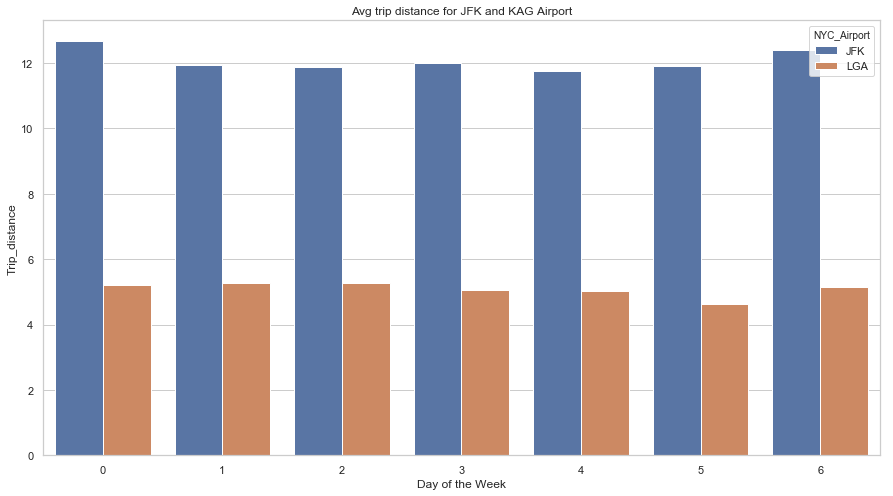

In [195]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
sns.barplot(x=airport_week_pickup.pickup_week.values, y=airport_week_pickup['Trip_distance'],hue=airport_week_pickup['NYC_Airport'] ,data=airport_week_pickup).set_title("Avg trip distance for JFK and KAG Airport")
plt.xlabel('Day of the Week')

From the graph we can see that trip distance for trips to LGA is quite shorter that the average trips to JFK Airport.

### Question 4

#### 4.1) Build a derived variable for tip as a percentage of the total fare

In [196]:
data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'pickup_hour',
       'pickup_week', 'dropoff_hour', 'dropoff_week', 'NYC_Airport'],
      dtype='object')

In [212]:
tip_data[tip_data['Total_amount']!=0].Total_amount

0           9.75
1          45.00
2           5.80
3           6.30
4           6.30
5           8.16
6           7.80
7           6.30
8           8.76
9           6.80
10          6.30
11          6.36
12          6.80
13          4.80
14          5.30
15          8.80
16          8.80
17          7.56
18          8.80
19          6.80
20          9.30
21          8.76
22         11.16
23          8.30
24         11.80
25          7.80
26         14.16
27          3.80
28          4.80
29          8.80
           ...  
1494896    16.30
1494897     6.35
1494898    17.85
1494899    11.30
1494900    20.30
1494901    29.75
1494902     6.80
1494903     7.80
1494904    10.80
1494905     9.30
1494906     8.80
1494907     7.25
1494908    24.35
1494909     9.30
1494910    17.15
1494911    10.35
1494912     9.80
1494913    15.80
1494914     6.80
1494915    24.35
1494916    24.35
1494917     7.30
1494918     7.30
1494919     7.30
1494920    21.00
1494921    31.80
1494922     9.30
1494923     8.

In [210]:
#Derived Column as a percent of total amount
tip_data=data.copy()
#Creating a copy of the original data as we will be dropping off columns where Total amount  is 0
tip_data['tip_percent']=tip_data['Tip_amount']/tip_data[tip_data['Total_amount']!=0].Total_amount*100

(0, 40)

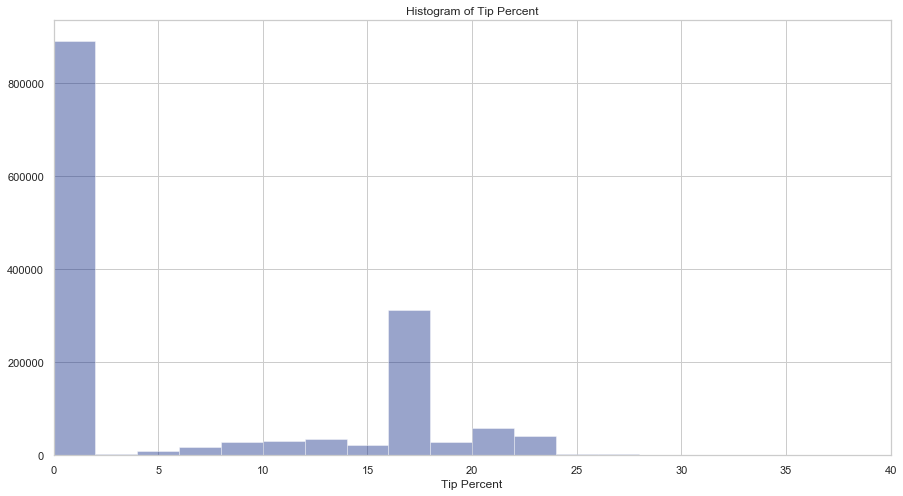

In [218]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid",palette="dark", color_codes=True)

sns.distplot(tip_data['tip_percent'].dropna(),hist=True,kde=False).set_title("Histogram of Tip Percent")
plt.xlabel("Tip Percent")
plt.xlim(0,40)


From the above histogram,we can infer that Tip is generally in the range of 10-25% of the total amount and most probably in the range of 15-20%.It is also observed that there are may instances where no tip was given.

In [24]:
!pip install geopy

In [75]:
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("40.6413 ,73.7781")
print(location.address)

### Question 4b.) Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.

### Model Building

The steps involved in building a predictive models are as follows

### 1) Data Cleaning & Exploration

The process of data cleaning is instrumental in revealing insights from the data that will eventually help in building a good predictive model

#### 1.1) Removing Extreme Trip Duration

In [428]:
url='https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
data=pd.read_csv(url)


In [429]:
#Pickup and DropOff datetime object columns.(It becomes easier to calculate difference between them in seconds )
data['pickup_dt']=data['lpep_pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['dropoff_dt']=data['Lpep_dropoff_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
#Pickup and Drop Off time in hour
data['pickup_time'] = data['lpep_pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)
data['dropoff_time'] = data['Lpep_dropoff_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)
#Total Trip Duration in seconds
data['Total_Trip_Duration'] = (data['dropoff_dt'] - data['pickup_dt']).apply(lambda x: x.total_seconds())


In [431]:
#Creating Copy of the data as we will need to drop many fields for creating our model
model_data=data.copy()

Text(0.5,0,'Trip_duration')

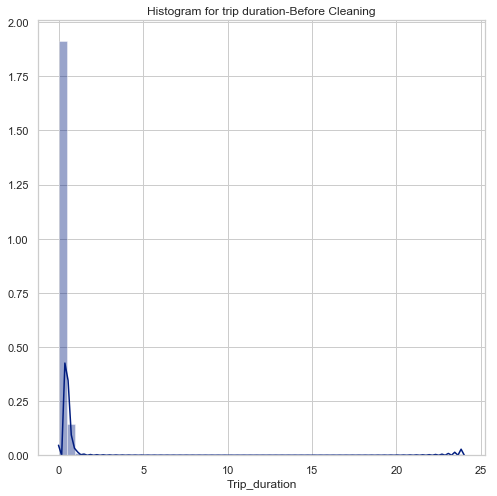

In [432]:
#fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)


plt.figure(figsize=(8,8))
sns.set(style='whitegrid',palette="dark", color_codes=True)
sns.distplot(data['Total_Trip_Duration']/3600,hist=True).set_title("Histogram for trip duration-Before Cleaning")
plt.xlabel("Trip_duration")


From the graph above we can observe that the trip duration is almost 24 hours in some of the cases whci seems to a an outlier while most of the trips lie betweem 0-5 hours

Text(0.5,0,'Trip_duration')

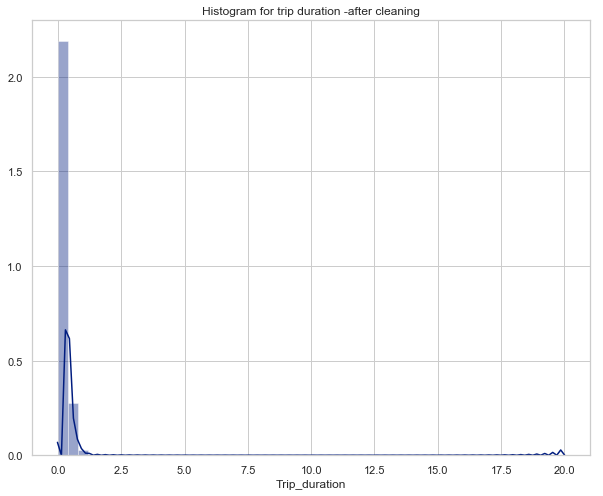

In [433]:
model_data=model_data[((model_data['Total_Trip_Duration']/3600)<20)]
#removing trips with less than > 20 hrs
plt.figure(figsize=(10,8))
sns.set(style='whitegrid',palette="dark", color_codes=True)
sns.distplot(model_data['Total_Trip_Duration']/3600,hist=True).set_title("Histogram for trip duration -after cleaning")
plt.xlabel("Trip_duration")


Text(0.5,0,'Trip Amount')

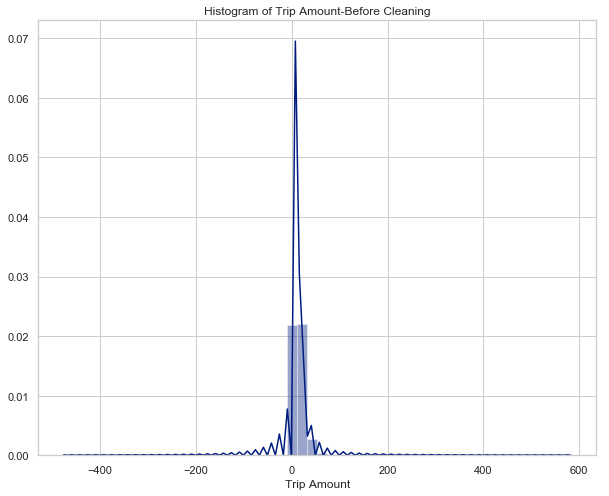

In [434]:
plt.figure(figsize=(10,8))
sns.set(style='whitegrid',palette="dark", color_codes=True)
sns.distplot(data['Total_amount'],hist=True).set_title("Histogram of Trip Amount-Before Cleaning")
plt.xlabel("Trip Amount")

There are trips with few trips with negative or 0 amount,we will exclude such trips for our model building.Also the base fare for green taxisis New York is 2.5 dollars so intuitively the total amount should not be less than that.We replace  the trips with total amount between 0-2.5 to $2.5.

In [435]:
model_data=model_data[model_data['Total_amount']>0]

model_data['Total_amount'].loc[model_data['Total_amount']<2.5]=2.5


In [436]:
model_data['Total_amount'].min()

2.5

Text(0.5,0,'Trip Amount')

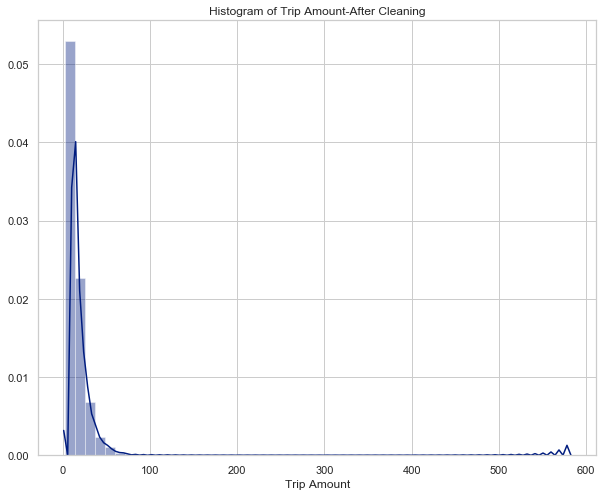

In [437]:
plt.figure(figsize=(10,8))
sns.set(style='whitegrid',palette="dark", color_codes=True)
sns.distplot(model_data['Total_amount'],hist=True).set_title("Histogram of Trip Amount-After Cleaning")
plt.xlabel("Trip Amount")

In [438]:

#Removing trips that are more than 600 miles as they again seem to be an outlier.
model_data=model_data[(model_data.Trip_distance<600)]


In [439]:
model_data.isnull().sum()

VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1481643
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      4
pickup_dt                      0
dropoff_dt                     0
pickup_time                    0
dropoff_time                   0
Total_Trip_Duration            0
dtype: int64

From the output above it is observed that Ehail_fee columns contains many Null values.We need to remove them before building our model

In [440]:
if 'Ehail_fee' in data.columns:
        model_data=model_data.drop('Ehail_fee',axis=1)

In [441]:
model_data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Total_amount',
       'Payment_type', 'Trip_type ', 'pickup_dt', 'dropoff_dt', 'pickup_time',
       'dropoff_time', 'Total_Trip_Duration'],
      dtype='object')

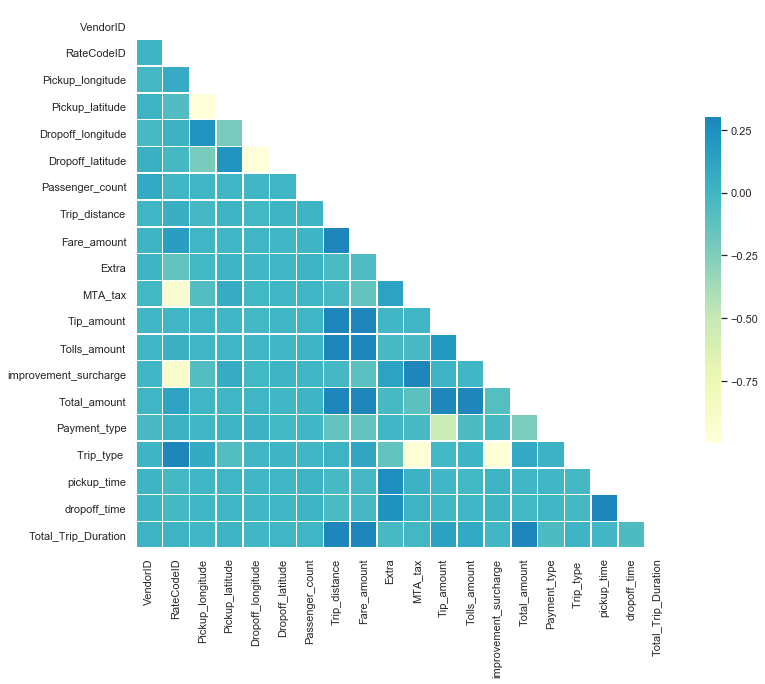

In [442]:
sns.set(style="white")
hm_data = model_data.copy() # dataframe
# Compute the correlation matrix
corr = hm_data.corr() # corr calculation
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap="YlGnBu", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Heatmap represents correlation between 2 variables and from the graph above it can be seen that variables like Tip_amount,Total_amount,Trip_distance,Fare_ampount,Tolls_amount are correlated.For our training our model we will only consider columns that have a good correlation and drop rest of the uncorrelated columns

Since the goal of the model is to predict tip of the trip,I am only considering transactions that have tips recorded .The value of tip is set to 0 under 2 conditions-1) when tip is given in Cash and 2) when tip is not given at all .Considering these records will give us inaccurate results .Hence to train the model ,I have considered only non-zero tip transactiosn

In [443]:
model_data=model_data[(model_data.Tip_amount>0)]

In [444]:
model_data['Tip_amount'].min()

0.01

In [445]:
#data['pickup_day']=data['lpep_pickup_datetime'].dt.day
#data['pickup_hour']=data['lpep_pickup_datetime'].dt.hour
#data['pickup_month']=data['lpep_pickup_datetime'].dt.month
#data['pickup_week']=data['lpep_pickup_datetime'].dt.weekofyear

In [446]:
model_data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Total_amount',
       'Payment_type', 'Trip_type ', 'pickup_dt', 'dropoff_dt', 'pickup_time',
       'dropoff_time', 'Total_Trip_Duration'],
      dtype='object')

In [447]:
model_data=model_data.drop(['VendorID','Store_and_fwd_flag','lpep_pickup_datetime','Lpep_dropoff_datetime','RateCodeID','Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude','pickup_dt','dropoff_dt','pickup_time','dropoff_time'],axis=1)

In [450]:
model_data.dtypes

Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_amount             float64
improvement_surcharge    float64
Total_amount             float64
Payment_type               int64
Trip_type                float64
Total_Trip_Duration      float64
tip_percent              float64
dtype: object

In [451]:
model_data['tip_percent']=model_data['Tip_amount']/model_data.Total_amount*100

#### Train/Test Splitting

Before building our model,we first split our data into 2 sets in the ratio of 80:20.Only this 80% of the complete data would be used to train our model and the rest 20% would be used to test on our trained model.The test dataset, however, is used to assess how well the algorithm was trained with the training dataset. One can’t simply reuse the training dataset in the testing stage because the algorithm will already “know” the expected output, which defeats the purpose of testing the algorithm.

In [452]:
model_data.shape[0]

600891

In [453]:
data_label=model_data['tip_percent'] #response variable
data_attributes=model_data.drop(['tip_percent'],axis=1) #predictor variables

In [454]:
X_train, X_test, y_train, y_test = train_test_split(data_attributes,data_label,test_size=0.20,random_state=100)

### <a id="linear"></a>Approach 1-  Multivariate Linear Regression
First, we will try [Linear Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) as it is the most widely-known and understood regression learner.  However, from the outset, it is important to underscore the assumptions we're making when using this model:
1. **The relationship between the independent and dependent variables is linear.**
2. **The variables (features) are normally distributed.  If not, a non-linear transformation (e.g., log-transformation) may be needed to fix the issue.  **
3. ** The independent variables (features) are not highly correlated with each other.**
4. **Residuals are independent of one another (i.e., outcome is independent of a previous outcome).**
5.  **Residuals are equal across the regression line.**

We are not sure if our data satisfies these assumptions.We can determine this by evaluating our test accuracy .

In [463]:
model_lin =  LinearRegression()
#Fit to training data 
model_lin.fit(X_train, y_train)

#Predicting the model
y_train_pred = model_lin.predict(X_train)
print("Training Metric")
output_analysis(y_train, y_train_pred)

y_test_pred = model_lin.predict(X_test)
print("\nTesting Metric")
output_analysis(y_test, y_test_pred)

Training Metric

Linear Regression Performance Metrics
R^2= 0.5718346770688104
MAE: 1.8428515546739535
MSE: 14.319480000734572
RMSE: 3.7841088780232752

Testing Metric

Linear Regression Performance Metrics
R^2= 0.45731177126605493
MAE: 1.8545974832476868
MSE: 18.085230174816655
RMSE: 4.252673297446755


In [467]:
def output_analysis(y_test,y_test_pred):
    print('\nPerformance Metrics')
    print('R^2=',metrics.explained_variance_score(y_test,y_test_pred))
    print('MAE:',metrics.mean_absolute_error(y_test,y_test_pred))
    print('MSE:',metrics.mean_squared_error(y_test,y_test_pred))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))

### <a id="linear"></a>Approach 2-  Random Forest Regressor
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [469]:
model_rf =  RandomForestRegressor(n_estimators = 100,max_depth=10,oob_score=True)
#Fit to training data 
model_rf.fit(X_train, y_train)

#Predicting the model
y_train_pred = model_rf.predict(X_train)
print("Training Metrics for Random Forest Regressor")
output_analysis(y_train, y_train_pred)

y_test_pred = model_rf.predict(X_test)
print("\nTesting Metric for Random Forest Regressor")
output_analysis(y_test, y_test_pred)

Training Metrics for Random Forest Regressor

Performance Metrics
R^2= 0.9547038654708644
MAE: 0.6164229940142459
MSE: 1.514875360233919
RMSE: 1.2308027300237512

Testing Metric for Random Forest Regressor

Performance Metrics
R^2= 0.9531464385123738
MAE: 0.6216091859721506
MSE: 1.561396835862414
RMSE: 1.2495586564313073


Before comparing the results from both the approaches we should first understand the intuition behind each of these metrics
1. **R-Squared error**:Also known as co-efficient of determination.It is the proportion of the variance in the dependent variable that is predictable from the independent variable.
2. **Mean Absolute Error**:Is a measure of difference between two continuous variables.In our case it is the absolute difference between the predicted vale and the actual value of the data point.MAE measures the average magnitude of the errors in a set of predictions, without considering their direction
3. **Mean Squared Error**: Is the average squared difference between the estimated values and what is estimated.It is always non-negative and values closer to zero are better.
4. **RMSE**:RMSE is a quadratic scoring rule that also measures the average magnitude of the error.It’s the square root of the average of squared differences between prediction and actual observation

#### Conclusion

The MSE of Linear regression is quite large (18) as compared to that of MSE from Random Forest Regressor(1.5).The values of MSE are expected to be closer to 1.Also the root mean square error of Random Forest is quiet less as compared to Linear Regression model
Compairing performance metrics of both the models we can conclude that Random Forest Regressor  has performed well than the Linear Regression Model in predicting the percent tip.


### Question 5

##### Choose only one of these options to answer for Question 5. There is no preference as to which one you choose. Please select the question that you feel your particular skills and/or expertise are best suited to. If you answer more than one, only the first will be scored.

#### Option A: Distributions

##### 5.1) Build a derived variable representing the average speed over the course of a trip.



In [586]:
url='https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
data=pd.read_csv(url)


In [587]:
#Pickup and DropOff datetime object columns.(It becomes easier to calculate difference between them in seconds )
data['pickup_dt']=data['lpep_pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['dropoff_dt']=data['Lpep_dropoff_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
#Pickup and Drop Off time in hour
data['pickup_time'] = data['lpep_pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)
data['dropoff_time'] = data['Lpep_dropoff_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)
#Total Trip Duration in seconds
data['Total_Trip_Duration'] = (data['dropoff_dt'] - data['pickup_dt']).apply(lambda x: x.total_seconds())


In [570]:
#Pickup hour and Week
data['lpep_pickup_datetime']=pd.to_datetime(data['lpep_pickup_datetime']) #Converting to datetime object
data['pickup_hour']=data['lpep_pickup_datetime'].dt.hour #Extracting the hour value
data['pickup_week']=data['lpep_pickup_datetime'].dt.dayofweek #Extracting the day of week value
#Drop-off Hour and Week
data['Lpep_dropoff_datetime']=pd.to_datetime(data['Lpep_dropoff_datetime'])  #Converting to datetime object
data['dropoff_hour']=data['Lpep_dropoff_datetime'].dt.hour #Extracting the hour value
data['dropoff_week']=data['Lpep_dropoff_datetime'].dt.dayofweek #Extracting the day of week value


Text(0.5,0,'Trip_duration in Hour')

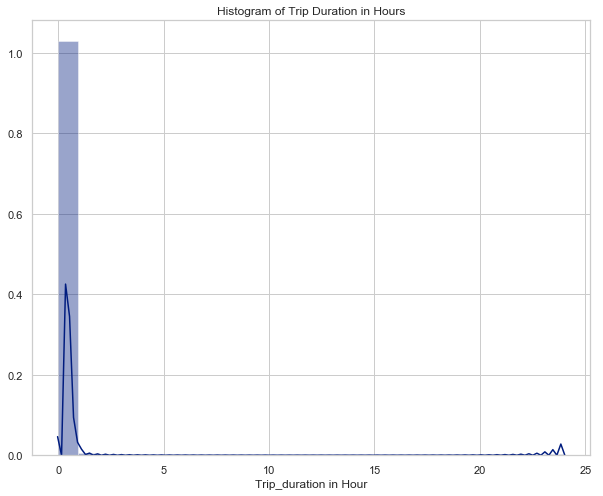

In [592]:
plt.figure(figsize=(10,8))
sns.set(style='whitegrid',palette="dark", color_codes=True)
sns.distplot(data['Total_Trip_Duration']/3600,bins=25,hist=True).set_title("Histogram of Trip Duration in Hours")
plt.xlabel("Trip_duration in Hour")

From the graph above we can see that there are some very long trips (25hrs) and some very short dutration trips which practically makes no sense as 
Dropping off trips that have durataion as 0 secs whcih is practically not possible.

In [589]:
data=data[data['Trip_distance']<600]

In [588]:
data=data[data['Total_Trip_Duration']!=0]
data['Total_Trip_Duratio']=data['Total_Trip_Duration']/3600

In [593]:
data=data[data['Total_Trip_Duration']>60]



In [594]:
data['Trip_avg_speed']=(data['Trip_distance']/data['Total_Trip_Duration'])*3600

Text(0.5,0,'Average Speed')

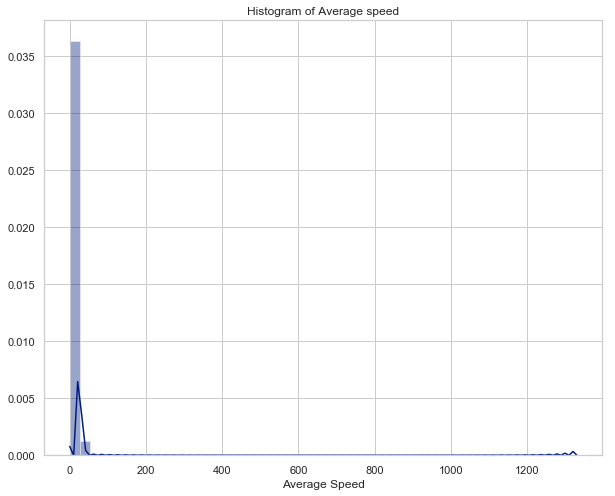

In [595]:
plt.figure(figsize=(10,8))
sns.set(style='whitegrid',palette="dark", color_codes=True)
sns.distplot(data['Trip_avg_speed'],hist=True).set_title("Histogram of Average speed")
plt.xlabel("Average Speed")


From the graph above we can see that there are trips that have more thhan 100 miles per hour speed which is not possible.The spped limit for taxis in NYC is 30mph so there are many outliers like the 1400 mph average speed.Excluding points beyond  100 mph we get the histogram as shown below.

In [600]:
#Excluding points beyond 100 mph
data=a=data[data['Trip_avg_speed']<100]
more_than_avg=data[data['Trip_avg_speed']>100]
#print("There are {} trips that have more than 100 mph average speed in NYC".format(more_than_avg.shape[0]))

There are 0 trips that have more than 100 mph average speed in NYC


Text(0.5,0,'Average Speed')

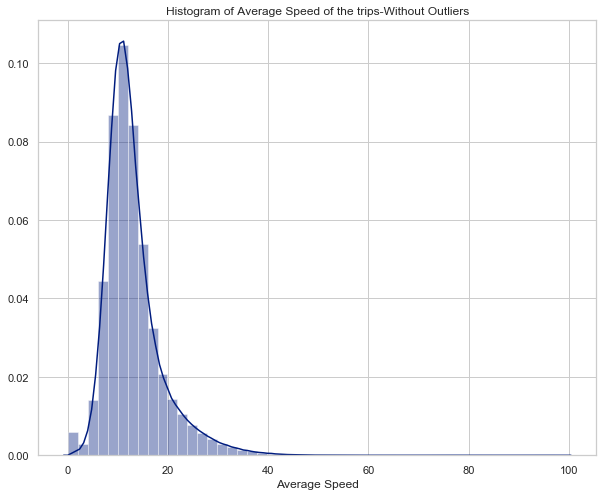

In [601]:
plt.figure(figsize=(10,8))
sns.set(style='whitegrid',palette="dark", color_codes=True)
sns.distplot(a.Trip_avg_speed,hist=True).set_title("Histogram of Average Speed of the trips-Without Outliers")
plt.xlabel("Average Speed")

From the histogram above we can say that most of the trips have average speed of 10-25 mph which looks pretty normal.

#### 5.2   Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

To determine if the averge trip speeds are same in all weeks of September I will be using ANOVA measure for my hypothesis testing.


#### What is ANOVA?

##### ANOVA (Analysis of Variance) is a statistical  technique used to determine whether there are any statistically significant differences between the means of two or more  groups.ANOVA generalizes the t-test to more than 2 gropus 

#### Why are we using ANOVA?

##### Since we intend to determine if average trip speeds are same in all weeks of September which means that we want to determine if sample means(avg trip speed) is same for two or more groups(Weeks of the September month).Hence AOVA test most appropriately fits our requirement

But before we can use ANOVA test we have to ensure that the underlying sample satisfies tha various assumptions of ANOVA
##### ANOVA Assumptions


##### 1)Independence of cases
##### 2) The distribution of residuals are normal(Caution-Normality and Normal Distribution of residuals is not the same!)
##### 3) Homoscedasticity or equality of variance

In [602]:
data['week'] = data['dropoff_dt'].apply(lambda x: x.week)

We will use two approaches to conduct our ANOVA test.In our 1st approach we will use statsmodel api to derive a simple 'Ordinary Least Square' model.In our 2nd approach we will use SciPy's 'stats' package and its f_oneway function to get our test statistics.The OLS model provide more information as compared to the Scipy's f_oneway which can be used for assumption checking and model diagnostic. Assumption checking is important before we can make any conclusion about our hypothesis

##### OLS Method

In [603]:
result=sm.OLS(data['Trip_avg_speed'],data['week']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Trip_avg_speed   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                 7.263e+06
Date:                Sun, 20 Jan 2019   Prob (F-statistic):               0.00
Time:                        18:43:35   Log-Likelihood:            -4.6682e+06
No. Observations:             1468913   AIC:                         9.336e+06
Df Residuals:                 1468912   BIC:                         9.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
week           0.3418      0.000   2695.077      0.000       0.342       0.342
==============================================================================
Omnibus:                   481316.504   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2190349.406
Skew:                           1.546   Prob(JB):                         0.00
Kurtosis:                       8.121   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We will now use the residue obtained from the above output to check our 2nd assumption.As the 2nd assumption is based on distribution of the residuals and not the samples itself

To check the normality of the residuals we will use 'Shapiro-Wilk test for normality' 
The Scipy's 'shapiro' function  takes input as an array of sample data(residual of result from OLS in our case) and returns the test statistic and p-vaue for the hypothesis test

##### Test for Normality -Shapiro-Wilk test

In [604]:
stats.shapiro(result.resid)

C:\Users\Rashmi\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9004066586494446, 0.0)

The official document of Shapiro says that " For N > 5000 the W test statistic is accurate but the p-value may not be."
Since because of the large data the p-value may not represent the test result accurately.So I tried one more method to determine normality of residuals i.e 'Anderson-Darling test'

#### Anderson Darling Test

In [605]:
res=stats.anderson(data['Trip_avg_speed'])

In [606]:
print('Statistic: %.3f' % res.statistic)
p = 0
for i in range(len(res.critical_values)):
    sl, cv = res.significance_level[i], res.critical_values[i]
    if res.statistic < res.critical_values[i]:
        print('%.3f: %.3f, data looks not normal ' % (sl, cv))
    else:
        print('%.3f: %.3f, data does look normal' % (sl, cv))

Statistic: 39053.708
15.000: 0.576, data does look normal
10.000: 0.656, data does look normal
5.000: 0.787, data does look normal
2.500: 0.918, data does look normal
1.000: 1.092, data does look normal


Considering both our above outputs we can say that the data follows a normality in distribution.We can now go ahead with our ANOVA hypothesis testing.


In [607]:
data.groupby(['week']).count()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Total_amount,Payment_type,Trip_type,pickup_dt,dropoff_dt,pickup_time,dropoff_time,Total_Trip_Duration,Total_Trip_Duratio,Trip_avg_speed
week,,,,,,,,,,,,,,,,,,,,,
36,293140,293140,293140,293140,293140,293140,293140,293140,293140,293140,...,293140,293140,293140,293140,293140,293140,293140,293140,293140,293140
37,357871,357871,357871,357871,357871,357871,357871,357871,357871,357871,...,357871,357871,357871,357871,357871,357871,357871,357871,357871,357871
38,353936,353936,353936,353936,353936,353936,353936,353936,353936,353936,...,353936,353936,353933,353936,353936,353936,353936,353936,353936,353936
39,333289,333289,333289,333289,333289,333289,333289,333289,333289,333289,...,333289,333289,333288,333289,333289,333289,333289,333289,333289,333289
40,130677,130677,130677,130677,130677,130677,130677,130677,130677,130677,...,130677,130677,130677,130677,130677,130677,130677,130677,130677,130677


In [608]:
week1_data=data[data['week']==36]
week2_data=data[data['week']==37]
week3_data=data[data['week']==38]
week4_data=data[data['week']==39]
week5_data=data[data['week']==40]

#### Test for Assuption 3: Equality of Variance

In [609]:
week1_data['Trip_avg_speed'].var()

34.11581826957573

In [610]:
week2_data['Trip_avg_speed'].var()

33.50897670095444

In [611]:
week3_data['Trip_avg_speed'].var()

31.898432559751818

In [612]:
week4_data['Trip_avg_speed'].var()

34.3282836044315

In [613]:
week5_data['Trip_avg_speed'].var()

32.494094245040515

From the above outputs we can see that there is not much a difference in the varince of the underlying sample and hence we can conclude that our distribution satisfies the 3rd assuption for ANOVA test


### Hypothesis for our ANOVA test

#### Null Hypothesis H0= Average Trip speed is same for all the weeks of September


#### Alternative Hypothesis H1=Average Trip is not same for all the weeks of September

### One Way ANOVA

Since we have one categorical input data Week of the month we can use One Way ANOVA

In [614]:
stats.f_oneway(week1_data.Trip_avg_speed,week2_data.Trip_avg_speed,week3_data.Trip_avg_speed,week4_data.Trip_avg_speed,week5_data.Trip_avg_speed)

F_onewayResult(statistic=1072.6164959451003, pvalue=0.0)

As the p-vlaue of our test is less than that of the alpha level 0.05 ** we reject our Null Hypothesis that the Trip speed is same for all weeks of September.**

#### 5.3)Can you build up a hypothesis of average trip speed as a function of time of day?

#### Null Hypothesis H0 :Average Trip speed is same for every hour of the day
#### Alternative Hypothesis H1: Average Trip Speed is not same for every hour of the day

In [328]:
data['dropoff_time'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 14, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [330]:
hours=range(24)
new_data = [data[data['dropoff_time']==h].dropoff_time for h in hours]


In [331]:
len(new_data[0])

71924

In [332]:
stats.f_oneway(new_data[0],new_data[1],new_data[2],new_data[3],new_data[4],new_data[5],new_data[6],new_data[7],
              new_data[8],new_data[9],new_data[10],new_data[11],new_data[12],new_data[13],new_data[14],new_data[15],
              new_data[16],new_data[17],new_data[18],new_data[19],new_data[20],new_data[21],new_data[22],new_data[23])

F_onewayResult(statistic=1.4964828671097507e+20, pvalue=0.0)

From the One Way ANOVA results we can see that p-value is greater that alpha=0.05 and hence we can reject our Null Hypothesis.
That means the average trip speed is not same for every hour and there is some correlation between the two.

Writing down individual list items as function parameter is a very naive approach,whcih could have been done using the eval function whcih takes  command as string but it could be a major security threat  eg "eval(rm...)"(which is removing files from OS) .Since the python notebook would be run on a different system I would not like to keep any security loop holes in my code.

(0, 30)

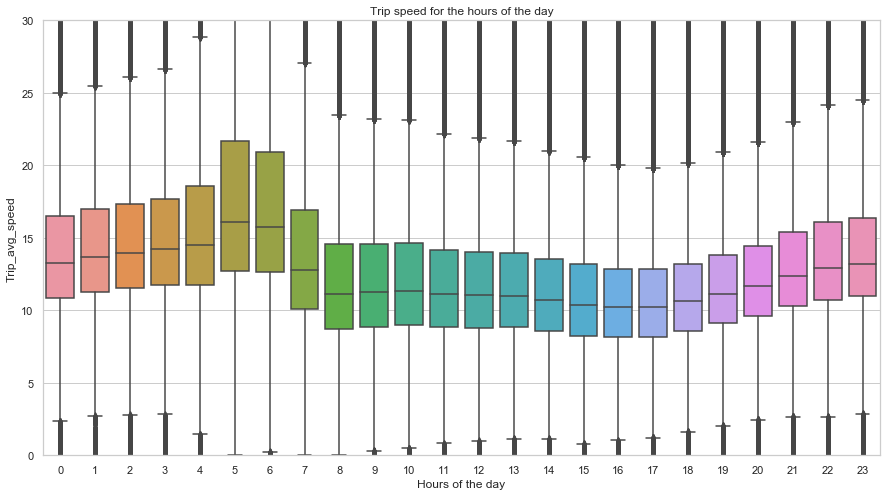

In [335]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
#ax=sns.boxplot(x=)
sns.boxplot(x=data['dropoff_time'], y=data['Trip_avg_speed'] ,data=data).set_title("Trip speed for the hours of the day")
plt.xlabel('Hours of the day')
plt.ylim(0,30) #To Limit the outliers

From the plot above we can say that the average trip speed is not same for every hour of the day.The average speed increases between 5.00 to 7.00 am reduces between 2.00 pm to 4.00 pm and again increases from 10.00pm to 12.00 pm
The average speed is the lowest at 8.00 am one possible reason for this might be the fact that its around 8-9.00 am that people tend to travel to work abd because of this there might be congestion on the roads and hence low avg spped.

### Power BI Visuals

##### 1) Passenger Count by pick-up location

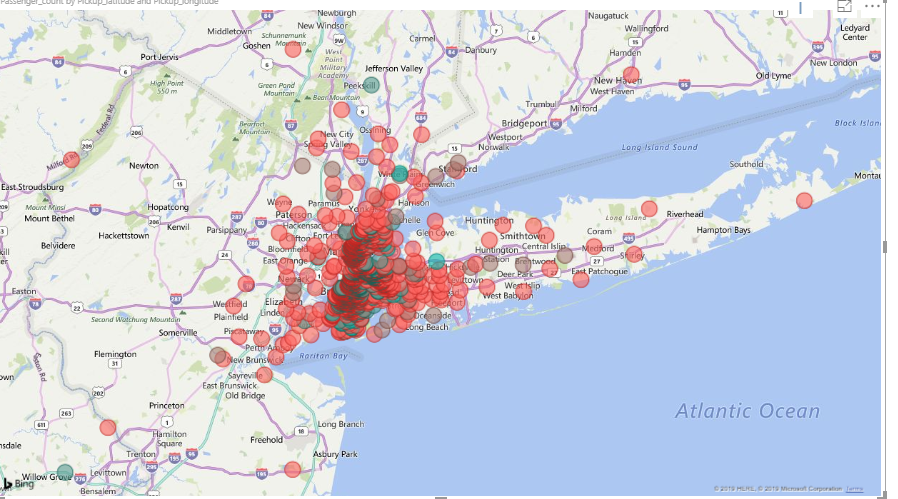

In [2]:
from IPython.display import Image
Image(filename='NYC Map.png')

The above graph depicts the number of passengers with respect to their pick-up location.The red dots are for 1 passenger count(min) and the green ones are for 4 passenger counts(max).From the plot it can be said that there are more single passengers trip than multi passenger trips.

#### 2) Trip Distance with respect to drop location

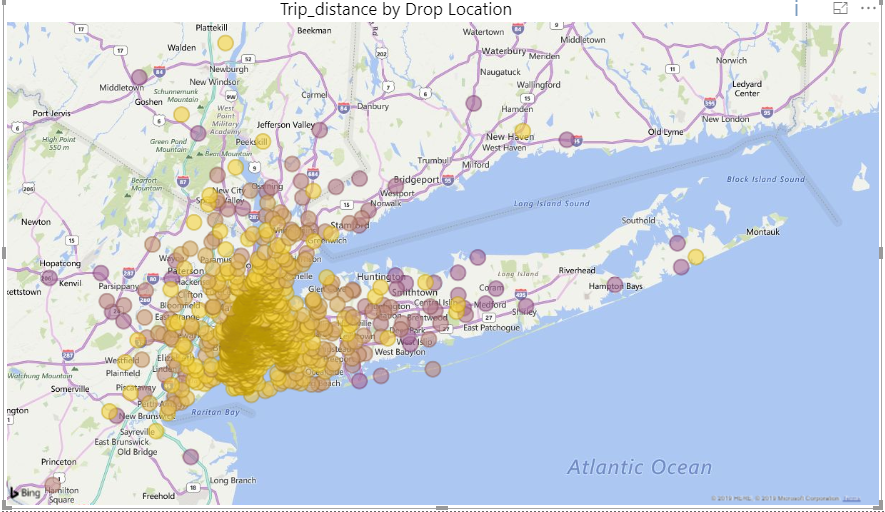

In [3]:
Image(filename='NYC_TripDistance.png')

From the graph shown above we can say that majority of the trips within the city were of shorter distancess.Shown by the yellow dots.The dpurple dots represent the trips with longer distances.The drop-off point for such longer distances trips is mostly on the outskirts of NYC.